In [8]:
import datetime
import os
import glob
import gc
import pandas as pd
import xarray as xr
import numpy as np
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib import colors

plt.style.use('science.mplstyle')
projectdir = '/glade/campaign/uwyo/wyom0112/berkeley/'
from params import homedir

In [6]:
boundaries = {'d01':{'CA': [43,60,35,68],
                     'WY': [68,81,43,63]},
              'd02':{'CA': [44,125,87,251],
                     'WY': [165,230,130,227]},
              'd03':{'CA': [0,-1,0,-1]},
              'd04':{'WY': [0,-1,0,-1]}}

colors_sides = {'lee': 'purple', 'wind':'firebrick'}


In [4]:
domains = ['d01', 'd02', 'd03', 'd04']
coordsdict = {}
for domain in domains:
    coordsdict[domain] = xr.open_dataset(f'/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/wrfinput_{domain}')

In [10]:
# huc4_16 = gpd.read_file(f'{homedir}data/huc16/WBDHU4.shp')
huc6_16 = gpd.read_file(f'{homedir}data/huc16/WBDHU6.shp')
huc8_16 = gpd.read_file(f'{homedir}data/huc16/WBDHU8.shp')
huc4_18 = gpd.read_file(f'{homedir}data/huc18/WBDHU4.shp')
huc6_18 = gpd.read_file(f'{homedir}data/huc18/WBDHU6.shp')
huc8_18 = gpd.read_file(f'{homedir}data/huc18/WBDHU8.shp')
huc4_10 = gpd.read_file(f'{homedir}data/huc10/WBDHU4.shp')
huc4_14 = gpd.read_file(f'{homedir}data/huc14/WBDHU4.shp')
huc8_14 =  gpd.read_file(f'{homedir}data/huc14/WBDHU8.shp')
huc8_10 =  gpd.read_file(f'{homedir}data/huc10/WBDHU8.shp')

In [14]:
## data
'''world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
huc2 = gpd.read_file(f'{projectdir}/fos-data/spatialdata/huc2.shp')'''
huc6 = gpd.read_file(f'{projectdir}/fos-data/spatialdata/huc6.shp')
metapath = '/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/'
coords1 = xr.open_dataset('/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/wrfinput_d01')
coords2 = xr.open_dataset('/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/wrfinput_d02')
coords4 = xr.open_dataset('/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/wrfinput_d04')
coords3 = xr.open_dataset('/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/wrfinput_d03')
coords_dict = {'d01': coords1, 
               'd02': coords2,
               'd03': coords3,
               'd04': coords4}

eco3 = gpd.read_file(f'{homedir}data/reg9_eco_l3.shp').to_crs('epsg:4326')
sn = eco3[eco3.US_L3NAME == 'Sierra Nevada']
huc8 = gpd.GeoDataFrame(pd.concat([huc8_16, huc8_18], ignore_index=True), crs=huc8_18.crs).to_crs('epsg:4326')
in_sn = huc8.sjoin(sn).reset_index()
in_sn.drop_duplicates(subset='name', inplace=True)
idx_lee = [1,4,2,0,3,29,30, 31, 32]
idx_wind = [i for i in in_sn.index if i not in idx_lee]
lines_wind= gpd.GeoSeries(in_sn.loc[idx_wind]['geometry'].boundary)
lines_lee = gpd.GeoSeries(in_sn.loc[idx_lee]['geometry'].boundary)
combined_wind = lines_wind.unary_union
combined_lee = lines_lee.unary_union
overlap = combined_wind.intersection(combined_lee)
gdf_overlap = gpd.GeoDataFrame(geometry=gpd.GeoSeries(overlap), crs=in_sn.crs)



In [15]:
elevation_min = 1000
elevation_max = 3500
elevation_step = 100
def prep_maps_elev(domain, state, asdf = 'eoc', gcm_mean = True):
    diff_eoc = xr.open_dataset(f'diff_{asdf}_BC_{domain}.nc').rename({'lat2d':'lat', 'lon2d':'lon'})
    if gcm_mean or (domain == 'd03') or (domain == 'd04'): diff_eoc = diff_eoc.mean(dim = 'gcm')
    elif not gcm_mean and not (domain == 'd03') and not (domain == 'd04'): diff_eoc = diff_eoc.sel(gcm = 3)# .mean(dim = 'gcm')
    left, right, bottom, top = boundaries[domain][state]
    domain_diff = diff_eoc.sel(lat = slice(bottom, top),lon = slice(left, right))
    coords = coords_dict[domain]
    coords = coords.sel(south_north = slice(bottom, top),west_east = slice(left, right))
    lat = coords['XLAT'][0]
    lat = coords['XLONG'][0]
    elev = coords['HGT'][0]
    elevation_data = elev.values
    elevation_bins = np.arange(elevation_min, elevation_max + elevation_step, elevation_step)
    if domain == 'd04': domain_diff = domain_diff.mean(dim = 'source_id')
    diff_vals = domain_diff['d_tas'].values
    elevation_mask = np.logical_and(elevation_data >= elevation_bins[:-1, np.newaxis, np.newaxis], elevation_data < elevation_bins[1:, np.newaxis, np.newaxis])
    sum_elev_bin = np.nansum((diff_vals  * elevation_mask), axis = (1,2))
    area_elev_bin = np.nansum((elevation_mask), axis = (1,2))
    mean_elev_bin = np.nanmean((diff_vals * elevation_mask), axis = (1,2))
    regional = {}
    
    if state == 'CA':   
        sidemasks = xr.open_dataset(f'masks_{domain}_sn.nc')
        sidenames = list(sidemasks.side.values)
        for i, subregion in enumerate(sidenames):
            regional[subregion] = {}
            regmask = sidemasks.sel(side = subregion).basin_mask.values
            diff_eoc_side = diff_eoc.where(regmask).sel(lat = slice(bottom, top),lon = slice(left, right))
            diff_vals = diff_eoc_side['d_tas'].values
            sum_elev_bin = np.nansum((diff_vals  * elevation_mask), axis = (1,2))
            area_elev_bin = np.nansum(elevation_mask, axis = (1,2))
            mean_elev_bin = np.nanmean((diff_vals * elevation_mask),axis = (1,2))

            regional[subregion] = {#'mean_dSdt_bin': mean_elev_bin,
                                   'sum_dSdt_bin': sum_elev_bin,
                                   #'sum_area': area_elev_bin,
                                   'diff_eoc':domain_diff,}

        
    outdict = {'state':state,
               'time' :asdf,
               #'mean_dSdt_bin': mean_elev_bin,
               'sum_dSdt_bin': sum_elev_bin,
               #'sum_area': area_elev_bin,
               'elev_bin':elevation_bins,
              'diff_eoc':domain_diff,
              'domain_coords':coords,
              'regional': regional}
    return outdict

    

In [18]:
gc.collect()
state_domains = {'WY': ['d01','d02', 'd04'],
                 'CA': ['d01','d02', 'd03']}

def prep_figdata(state):
    domains = state_domains[state]
    maps = []
    for domain in domains:
        info = prep_maps_elev(domain, state, 'eoc', gcm_mean = True)
        diff_eoc = info['diff_eoc']
        elev_bins = info['elev_bin']
        domain_coords = info['domain_coords']
        lon_array = domain_coords['XLONG'][0]
        lat_array = domain_coords['XLAT'][0]
        maps.append([lon_array, lat_array, diff_eoc['d_tas']])
        gc.collect()
    print(len(maps))
    profiles_e = []
    profiles_m = []
    sidenames = ['lee','wind']
    for domain in domains:
        info_e = prep_maps_elev(domain, state, 'eoc', gcm_mean = False)
        info_m = prep_maps_elev(domain, state, 'midc', gcm_mean = False)
        if state == 'CA':
            for i, subregion in enumerate(sidenames):
                data = info_e['regional'][subregion]['sum_dSdt_bin']
                profiles_e.append(data)
                data = info_m['regional'][subregion]['sum_dSdt_bin']
                profiles_m.append(data)
        elif state == 'WY':
            data = info_e['sum_dSdt_bin']
            profiles_e.append(data)
            data = info_m['sum_dSdt_bin']
            profiles_m.append(data)
        gc.collect()
    print(len(profiles_e))
    print(len(profiles_m))
    return maps, profiles_e, profiles_m, elev_bins

3
3
3


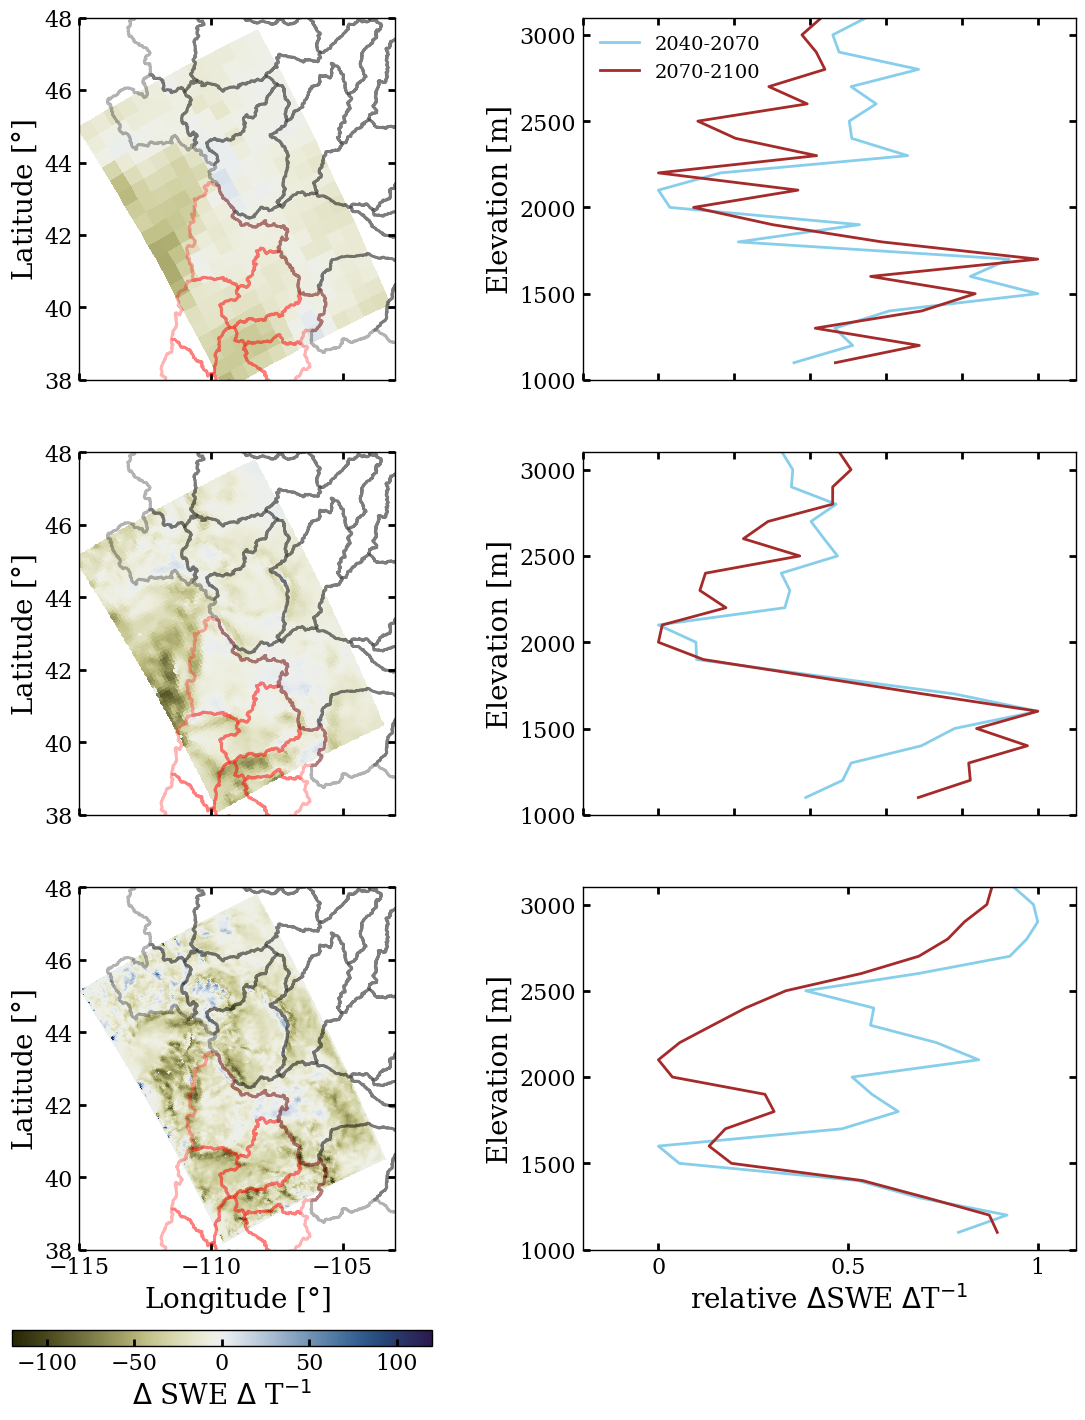

In [19]:
## WYOMING ##
import cmcrameri.cm as ccm
maps, profiles_e, profiles_m, elev_bins = prep_figdata('WY')
cmap = ccm.broc_r
fig,ax = plt.subplots(3,2, figsize = (14,16))
axs = ax.flatten()
e = elev_bins[1:]
k=0
axs[1].plot([-100,-10],[-100,-10],color = 'skyblue',label = '2040-2070')
axs[1].plot([-100,-10],[-100,-10],color = 'brown',label = '2070-2100')

for i in range(3):
    lon,lat,mapdata = maps[i]
    cb = axs[k].pcolormesh(lon,lat,mapdata, cmap = cmap, vmin = -120, vmax = 120)
    
    ## midc ##
    leeplot = profiles_m[i]
    leeplot = (leeplot-np.nanmin(leeplot))/ (np.nanmax(leeplot) - np.nanmin(leeplot))
    axs[k+1].plot(leeplot,e, linestyle = '-', color = 'skyblue')
    
    ##eoc##
    leeplot = profiles_e[i]
    leeplot = (leeplot-np.nanmin(leeplot))/ (np.nanmax(leeplot) - np.nanmin(leeplot))
    axs[k+1].plot(leeplot,e, linestyle = '-', color = 'brown')

    ## formatting
    axs[k].set_xlim((-115, -103))
    axs[k].set_ylim((38,48))
    axs[k].set_ylabel(r'Latitude [$\degree$]', fontsize = 20)
    axs[k+1].set_ylabel('Elevation [m]', fontsize = 20)
    ##
    huc4_14.boundary.plot(ax = axs[k], color = 'r',linestyle = '-', alpha = 0.3)
    huc4_10.boundary.plot(ax = axs[k], color = 'k',linestyle = '-', alpha = 0.3)
    ##
    axs[k+1].set_xticklabels([])
    axs[k+1].set_ylim((1000,3100))
    axs[k+1].set_xlim((-0.2,1.1))
    if i < 2:
        axs[k].set_xticklabels([])
    k+=2

h,l = axs[1].get_legend_handles_labels()  
axs[1].legend(h, l, loc = 'upper left', ncol = 1)
axs[k-2].set_xlabel(r'Longitude [$\degree$]', fontsize = 20)
axs[k-1].set_xticks([0, 0.5, 1])
axs[k-1].set_xticklabels([0, 0.5, 1])
axs[k-1].set_xlabel(r'relative $\Delta$SWE $\Delta$T$^{-1}$', fontsize = 20)

cax = fig.add_axes([0.14, 0.05, 0.3, 0.01])  # left, bottom, width, height
cbar = plt.colorbar(cb, cax=cax, orientation='horizontal')
cbar.set_label(r'$\Delta$ SWE $\Delta$ T$^{-1}$', fontsize = 20)

plt.show()
    
    
    
    

In [ ]:
import cmcrameri.cm as ccm
maps, profiles_e, profiles_m, elev_bins = prep_figdata('CA')

cmap = ccm.broc_r
fig,ax = plt.subplots(3,2, figsize = (12,16))
axs = ax.flatten()
e = elev_bins[1:]
k=0
axs[1].plot([-100,-10],[-100,-10],'k-',label = 'Windward')
axs[1].plot([-100,-10],[-100,-10],'k--',label = 'Leeward')

axs[1].plot([-100,-10],[-100,-10],color = 'skyblue',label = '2040-2070')
axs[1].plot([-100,-10],[-100,-10],color = 'brown',label = '2070-2100')

for i in range(3):
    lon,lat,mapdata = maps[i]
    cb = axs[k].pcolormesh(lon,lat,mapdata, cmap = cmap, vmin = -120, vmax = 120)
    
    in_sn.loc[idx_lee].boundary.plot(ax=axs[k], color = 'k',linestyle = '--', alpha = 0.3)
    in_sn.loc[idx_wind].boundary.plot(ax=axs[k], color = 'k', alpha = 0.3)
    gdf_overlap.plot(ax=axs[k], color =  'orchid')# '#332288' )#'purple')

    ## midc ##
    leeplot = profiles_m[k]
    windplot = profiles_m[k+1]
    leeplot = (leeplot-np.nanmin(leeplot))/ (np.nanmax(leeplot) - np.nanmin(leeplot))
    windplot = (windplot-np.nanmin(windplot))/ (np.nanmax(windplot) - np.nanmin(windplot))
    axs[k+1].plot(1-leeplot,e, linestyle = '--', color = 'skyblue')
    axs[k+1].plot(windplot-1,e, linestyle = '-', color = 'skyblue')
    
    ##eoc##
    leeplot = profiles_e[k]
    windplot = profiles_e[k+1]
    leeplot = (leeplot-np.nanmin(leeplot))/ (np.nanmax(leeplot) - np.nanmin(leeplot))
    windplot = (windplot-np.nanmin(windplot))/ (np.nanmax(windplot) - np.nanmin(windplot))
    axs[k+1].plot(1-leeplot,e, linestyle = '--', color = 'brown')
    axs[k+1].plot(windplot-1,e, linestyle = '-', color = 'brown')

    ## formatting
    axs[k].set_xlim((-121, -118))
    axs[k].set_ylim((36,39.5))
    axs[k+1].set_ylabel('Elevation [m]', fontsize = 20)
    axs[k+1].set_xticklabels([])
    axs[k+1].vlines(x=0, ymin=1000, ymax=3500, color='orchid', linewidth=1)
    axs[k+1].fill_betweenx([900,3500], -2, 0, alpha=0.3, color='gray')
    axs[k+1].set_ylim((1000,3100))
    axs[k+1].set_xlim((-1.1,1.1))
    
    k+=2
h, l = axs[1].get_legend_handles_labels()
h.insert(2, h[0])
l.insert(2, '')
axs[1].legend(h[0:2], l[0:2], loc = 'upper center', ncol = 2)
axs[1].twinx().legend(h[3:], l[3:], loc = 'upper left', ncol = 1, bbox_to_anchor = (0.065,0.92))
axs[k-1].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[k-1].set_xticklabels([1, 0.5, 0, 0.5, 1])
axs[k-1].set_xlabel(r'relative $\Delta$SWE $\Delta$T$^{-1}$', fontsize = 20)

cax = fig.add_axes([0.20, 0.08, 0.20, 0.01])  # left, bottom, width, height
cbar = plt.colorbar(cb, cax=cax, orientation='horizontal', extend = 'both')

plt.show()
    
    
    
    

first


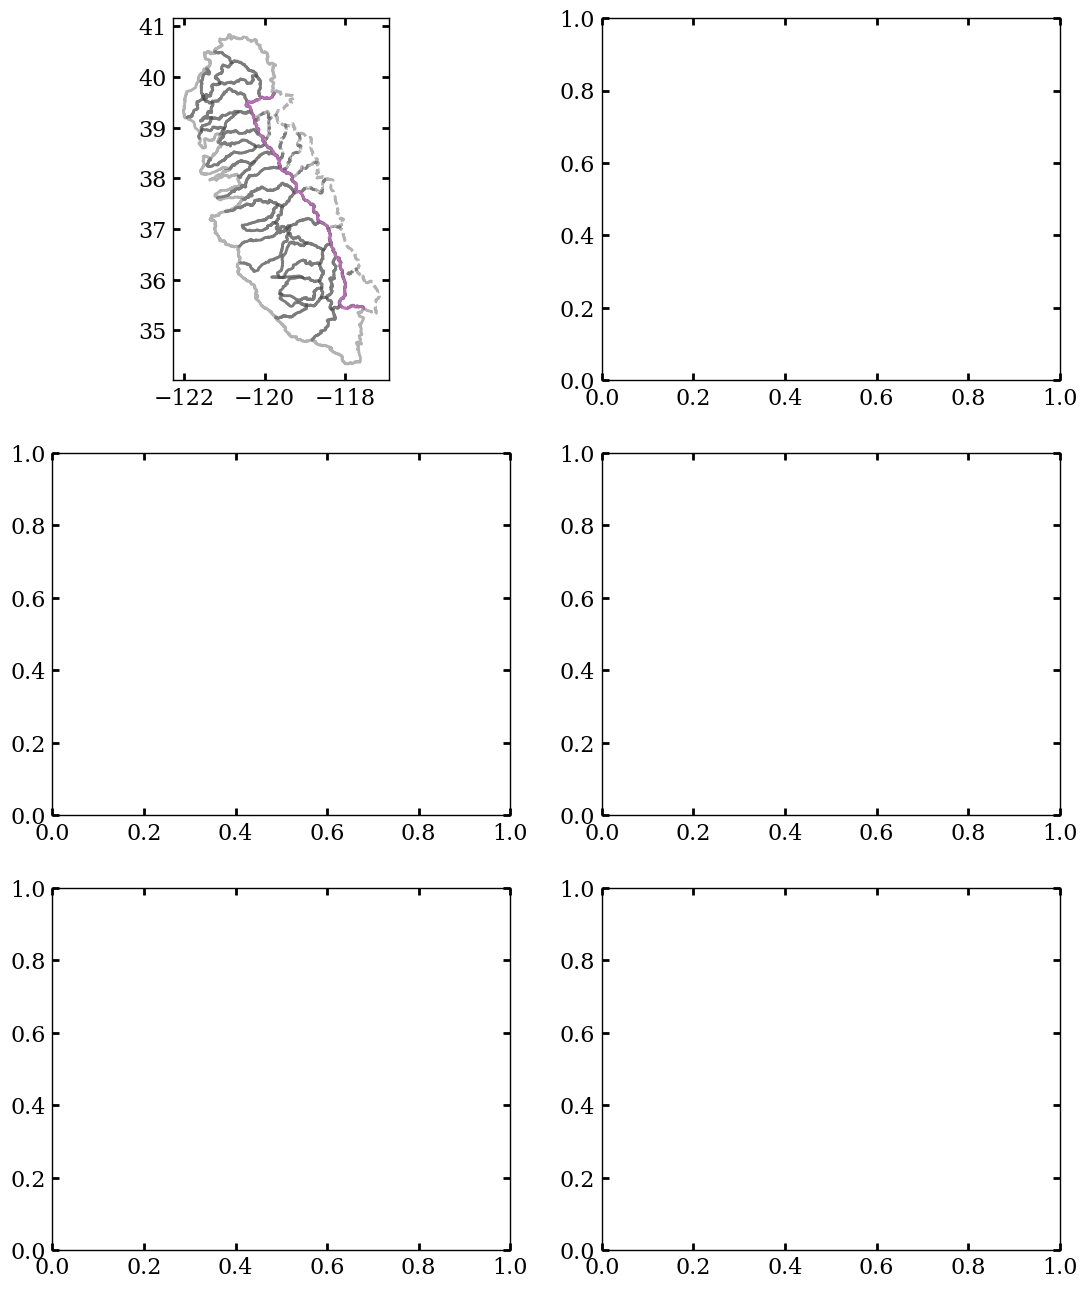

In [22]:
import cmcrameri.cm as ccm
fig,ax = plt.subplots(3,2, figsize = (13,16))
cmap = ccm.broc_r
axs = ax.flatten()
NORM = True
elevation_min = 1000
elevation_max = 3000
elevation_step = 100
style = {'lee': '--',
         'wind': '-',
         'prec': 'darkblue',
         'temp': 'orchid'}
yrcolors = ["black", "#332288","#88CCEE","#44AA99","#117733",
            "#999933","#DDCC77","#CC6677","#882255","#AA4499","brown","#fd3c06","gray"]

yrcolors = ["gray", "#88CCEE","#117733" ]


k = 0
custom_xtick_labels = ['1','0','1']
xtick_locations = [-1, 0,1]
state = 'CA'
gc.collect()
domains = ['d01','d02','d03']
maps = []
datas = []
for domain in domains[0:1]:
    sidemasks = xr.open_dataset(f'masks_{domain}_sn.nc')
    info = prep_maps_elev(domain, state, 'eoc')
    sidenames = list(sidemasks.side.values)
    diff_eoc = info['diff_eoc']
    elev_bins = info['elev_bin']
    domain_coords = info['domain_coords']
    lon_array = domain_coords['XLONG'][0]
    lat_array = domain_coords['XLAT'][0]
    #cb = axs[k].pcolormesh(lon_array, lat_array, diff_eoc['d_tas'], cmap = cmap, vmin = -120, vmax = 120)
    maps.append([lon_array, lat_array, diff_eoc['d_tas']])
    del(domain_coords)
    #axs[k].set_xlim((-121, -118))
    #axs[k].set_ylim((36,39.5))
    print('first')
    for i, subregion in enumerate(sidenames):
        data = info['regional'][subregion]['sum_dSdt_bin']
        data = np.abs(data)
        e = elev_bins[1:]

        label = None
        if subregion == 'wind': 
            data = -data
        #if NORM:
        #    data = (data-np.nanmin(data))/ (np.nanmax(data) - np.nanmin(data))
    
        
        #axs[k+1].plot(data, 
        #        e,#  linestyle = '-', #style[subregion], 
        #        label =  label, color = colors_sides[subregion])
        datas.append(data)
        
        #data = info['regional'][subregion]['sum_dSdt_bin']
        #axs[k+1].plot(data, 
        #        e, linestyle ='--', 
        #        label =  label, color = colors_sides[subregion])
        gc.collect()

    del(info)
    gc.collect()
    in_sn.loc[idx_lee].boundary.plot(ax=axs[k], color = 'k',linestyle = '--', alpha = 0.3)
    in_sn.loc[idx_wind].boundary.plot(ax=axs[k], color = 'k', alpha = 0.3)
    gdf_overlap.plot(ax=axs[k], color =  'orchid')# '#332288' )#'purple')
    gc.collect()
    '''
    axs[k+1].set_ylabel('Elevation [m]', fontsize = 20)
    axs[k+1].set_xticklabels([])
    axs[k+1].vlines(x=0, ymin=1000, ymax=3500, color='orchid', linewidth=1)
    axs[k+1].fill_betweenx([900,3500], -2, 0, alpha=0.3, color='gray', label='Shaded Area')
    axs[k+1].vlines(x=0, ymin=900, ymax=3500, color='black', linewidth=1)
    axs[k+1].set_ylim((1000,3100))
    axs[k+1].set_xlim((-1.1,1.1))
    k+=2
axs[k-1].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[k-1].set_xticklabels([1, 0.5, 0, 0.5, 1])
axs[k-1].set_xlabel('relative dSWE dT', fontsize = 20)

#cax = fig.add_axes([0.20, 0.08, 0.25, 0.01])  # left, bottom, width, height
#cbar = plt.colorbar(cb, cax=cax, orientation='horizontal')
plt.show()
gc.collect()
    '''

IndexError: list index out of range

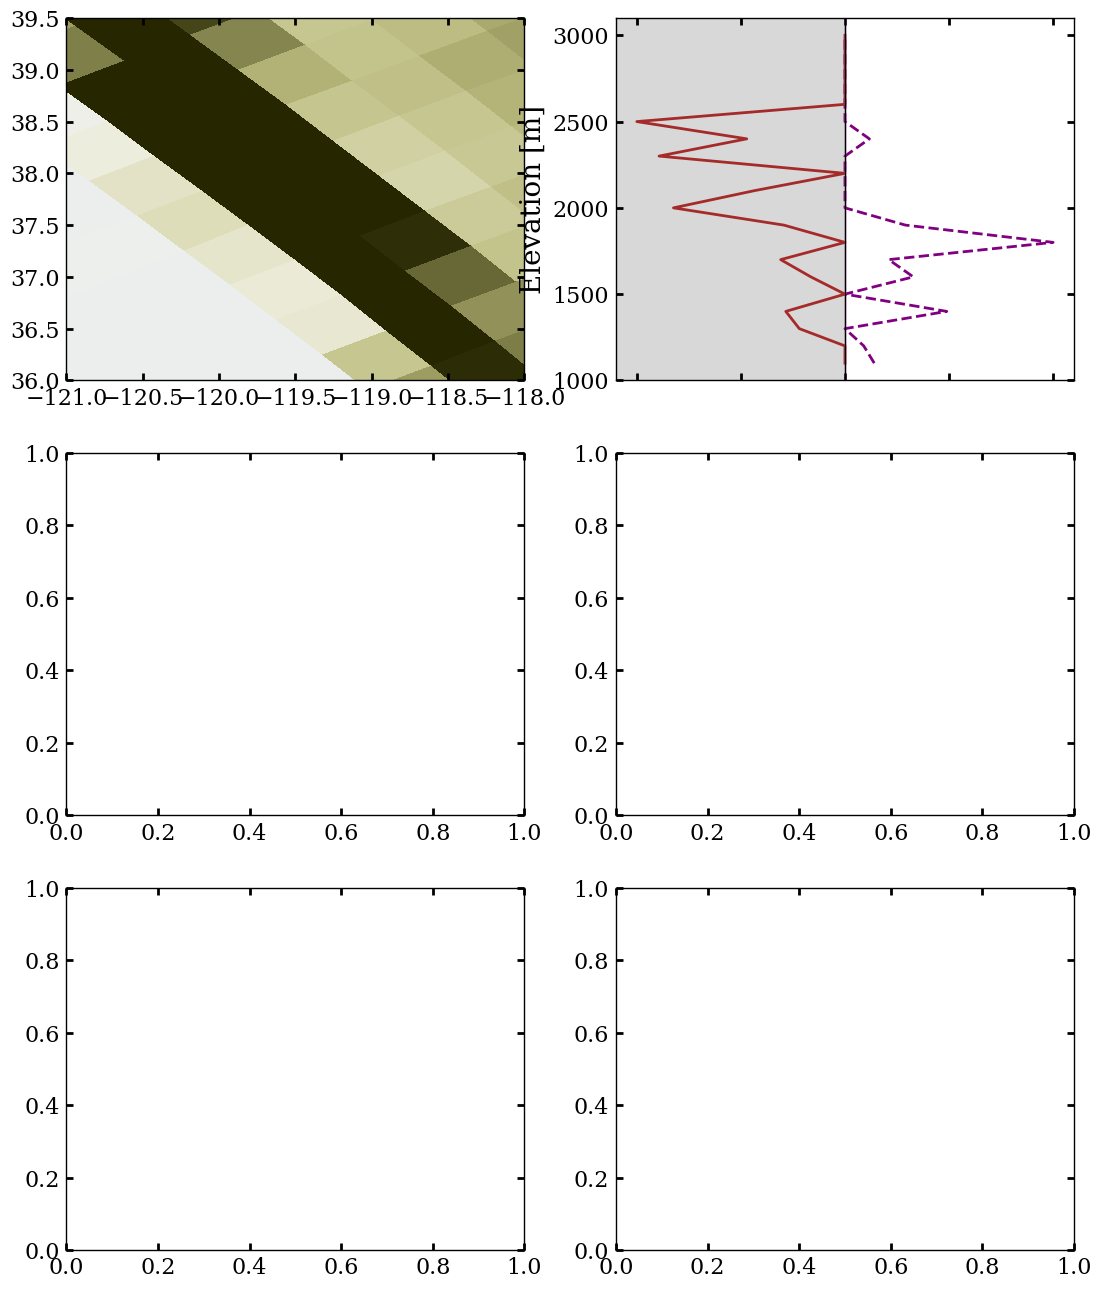

In [23]:
fig,ax = plt.subplots(3,2, figsize = (13,16))
axs = ax.flatten()
k=0
for i in range(2):
    lon,lat,data = maps[i]
    leeplot = datas[k]
    windplot = datas[k+1]
    axs[k].pcolormesh(lon,lat,data, cmap = cmap, vmin = -120, vmax = 120)
    
    leeplot = (leeplot-np.nanmin(leeplot))/ (np.nanmax(leeplot) - np.nanmin(leeplot))
    windplot = (windplot-np.nanmin(windplot))/ (np.nanmax(windplot) - np.nanmin(windplot))
    axs[k+1].plot(1-leeplot,e, linestyle = '--', color = 'purple')
    axs[k+1].plot(-windplot,e, linestyle = '-', color = 'brown')
    ## formatting
    
    axs[k].set_xlim((-121, -118))
    axs[k].set_ylim((36,39.5))
    axs[k+1].set_ylabel('Elevation [m]', fontsize = 20)
    axs[k+1].set_xticklabels([])
    axs[k+1].vlines(x=0, ymin=1000, ymax=3500, color='orchid', linewidth=1)
    axs[k+1].fill_betweenx([900,3500], -2, 0, alpha=0.3, color='gray', label='Shaded Area')
    axs[k+1].vlines(x=0, ymin=900, ymax=3500, color='black', linewidth=1)
    axs[k+1].set_ylim((1000,3100))
    axs[k+1].set_xlim((-1.1,1.1))
    
    k+=2
    
plt.show()
    
    